## Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

## Getting data

In [2]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [3]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [4]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [5]:
train_df.head(3)

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.0,2000.0,842398,377,257504,27026398,...,0.003691,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.235616
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.0,2100.0,854253,385,235750,26955617,...,0.002557,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.260491
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.0,1975.0,714655,384,194733,26886977,...,0.001970,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.230759


## Data viz exploration

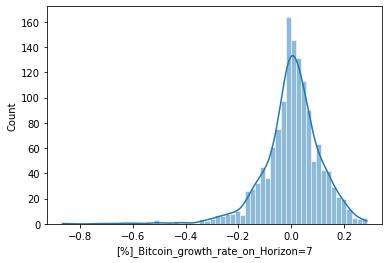

In [6]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

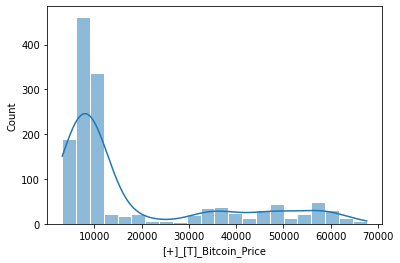

In [7]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [8]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();

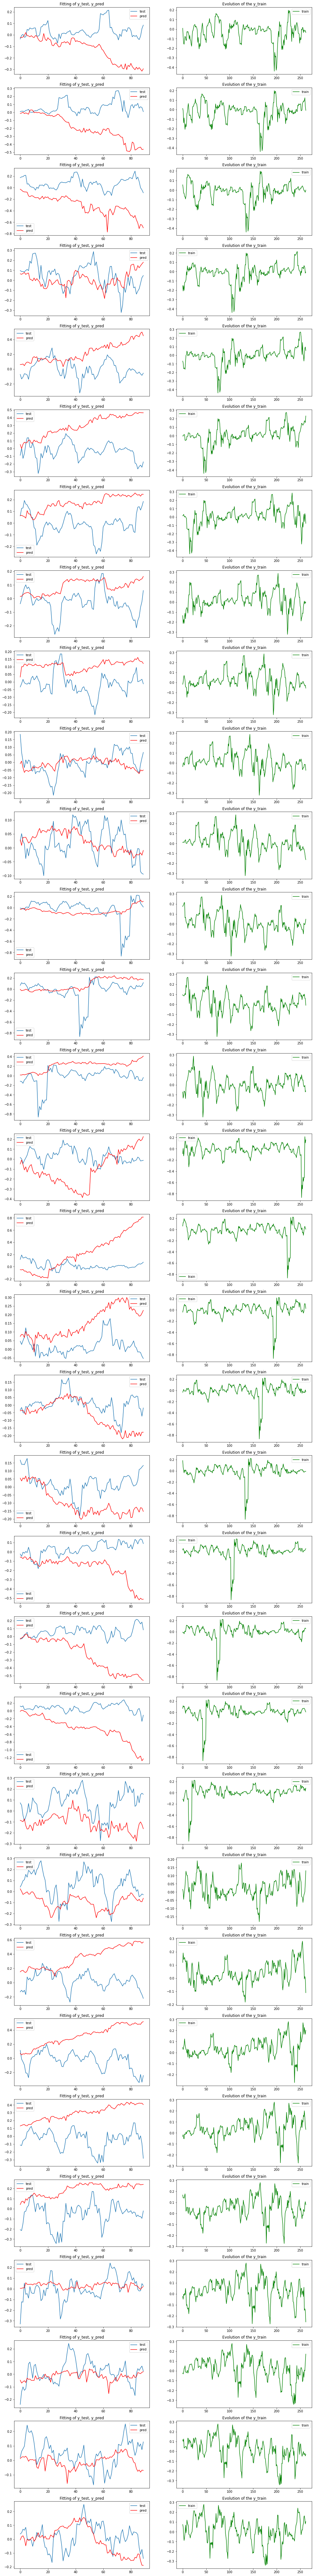

In [9]:
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = 0.008 , l1_ratio = 0.0005))

In [10]:
#ypred j+7 - ypred j+1 / ypred j+7
#ypred_diff.apply(lambda x: x*())

## Analysing Coefs

### Elastic Net training

In [11]:
model_regression = LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.10it/s]

Training done


array([-0.02563215, -0.02351018, -0.1172471 ,  0.01618947,  0.02502631,
       -0.07652867, -0.04216135,  0.01149051,  0.01759974, -0.1004982 ,
       -0.04336702, -0.01745885, -0.06656645,  0.01405138, -0.05703787,
       -0.08753245,  0.02875386, -0.05529203, -0.09185395, -0.08621512,
       -0.04691511,  0.01162086,  0.00644276, -0.0065283 ,  0.03556286,
        0.01566798,  0.12198131,  0.0469917 , -0.07698   ,  0.01957013,
       -0.13662976,  0.01584781])

In [12]:
train_df_matrix = train_df.copy().drop(columns = 'date')
len(train_df_matrix.columns)

32

In [13]:
coeff_matrix = pd.DataFrame(zip(train_df_matrix.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

,features,coeff abs
0,[+]_[T]_Bitcoin_Price,0.136630
1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,0.121981
2,[//]_[AV]_Stock-to-Flow_Ratio,0.117247
3,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,0.100498
4,[$]_[BSB]_Realized_Price,0.091854
5,[$]_[BSB]_Exchange_Net_Position_Change_-_All_E...,0.087532
6,[%]_[BSB]_Price_Drawdown_from_ATH,0.086215
7,[+]_[NH]_Number_of_Addresses_with_Balance_100 ...,0.076980
8,[+]_[NH]_Number_of_Active_Addresses,0.076529
9,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),0.066566


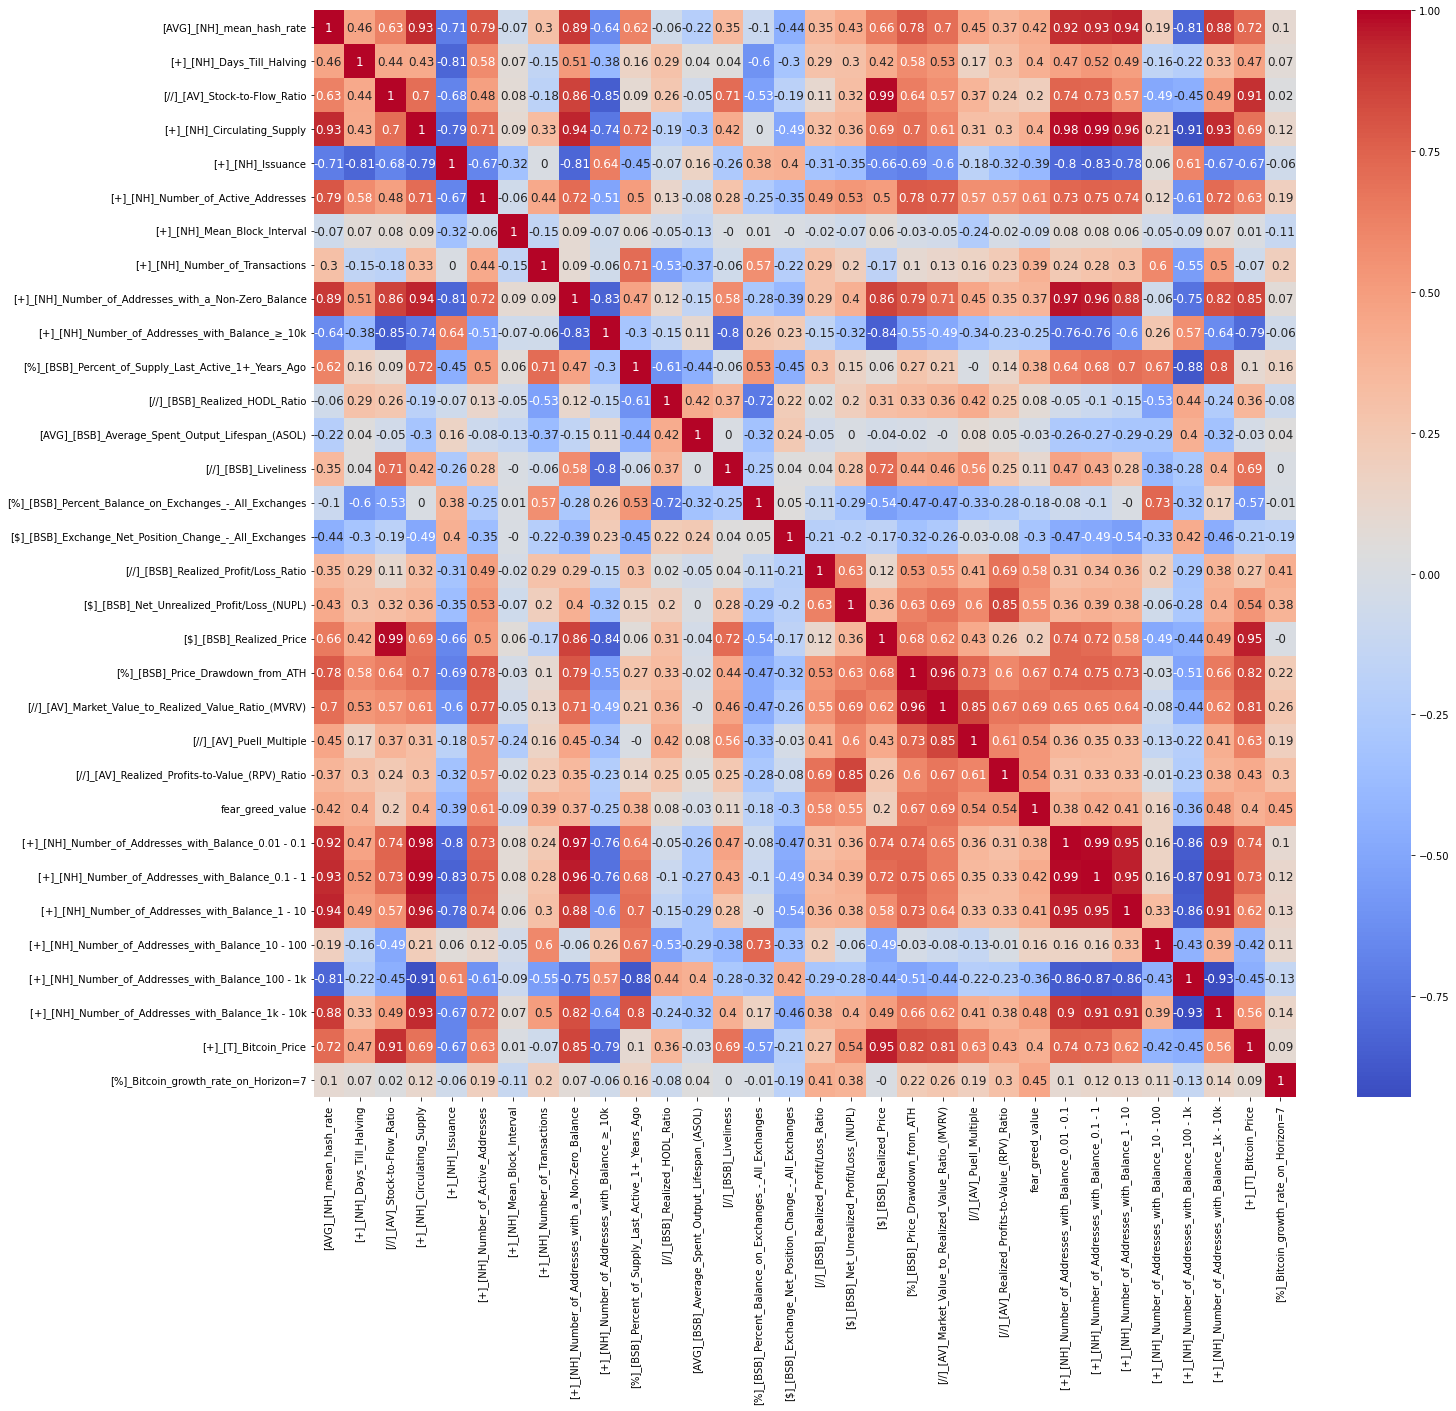

In [14]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df_matrix.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [15]:
train_df_matrix.corr().style.background_gradient(cmap='coolwarm')

,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k,[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago,[//]_[BSB]_Realized_HODL_Ratio,[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL),[//]_[BSB]_Liveliness,[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges,[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges,[//]_[BSB]_Realized_Profit/Loss_Ratio,[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL),[$]_[BSB]_Realized_Price,[%]_[BSB]_Price_Drawdown_from_ATH,[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV),[//]_[AV]_Puell_Multiple,[//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7
[AVG]_[NH]_mean_hash_rate,1.000000,0.463162,0.630272,0.927254,-0.713023,0.786381,-0.073801,0.301860,0.891833,-0.643322,0.618119,-0.063496,-0.223503,0.347550,-0.101402,-0.437090,0.352117,0.431304,0.659304,0.780823,0.701315,0.454142,0.365043,0.423765,0.918904,0.930719,0.943290,0.194657,-0.805036,0.875091,0.720093,0.099333
[+]_[NH]_Days_Till_Halving,0.463162,1.000000,0.436686,0.429657,-0.805983,0.578631,0.065331,-0.149927,0.508994,-0.375368,0.157318,0.289766,0.043285,0.036267,-0.600147,-0.301794,0.293104,0.304748,0.421554,0.576468,0.527815,0.167947,0.304031,0.400049,0.468325,0.524134,0.490902,-0.162074,-0.221128,0.328114,0.468869,0.071926
[//]_[AV]_Stock-to-Flow_Ratio,0.630272,0.436686,1.000000,0.699625,-0.677524,0.480806,0.080088,-0.175301,0.862580,-0.854968,0.093267,0.264620,-0.049654,0.707004,-0.527314,-0.189448,0.111482,0.316725,0.987622,0.641979,0.567133,0.371118,0.237082,0.197502,0.741116,0.729136,0.567840,-0.491804,-0.454631,0.488282,0.907228,0.016407
[+]_[NH]_Circulating_Supply,0.927254,0.429657,0.699625,1.000000,-0.786063,0.714104,0.086624,0.326221,0.937293,-0.743304,0.722398,-0.186994,-0.300755,0.417440,0.001863,-0.487898,0.321092,0.364316,0.692872,0.700965,0.606103,0.311283,0.303428,0.395860,0.983193,0.988826,0.956484,0.213059,-0.910020,0.927786,0.692906,0.116837
[+]_[NH]_Issuance,-0.713023,-0.805983,-0.677524,-0.786063,1.000000,-0.668086,-0.320479,0.001770,-0.812060,0.642768,-0.448694,-0.071819,0.158712,-0.264509,0.377007,0.403575,-0.307451,-0.348981,-0.661812,-0.685705,-0.601294,-0.176091,-0.321128,-0.394968,-0.796507,-0.833646,-0.777212,0.063212,0.611146,-0.672511,-0.668621,-0.056325
[+]_[NH]_Number_of_Active_Addresses,0.786381,0.578631,0.480806,0.714104,-0.668086,1.000000,-0.056700,0.435906,0.721946,-0.508453,0.502838,0.127929,-0.076097,0.278546,-0.250836,-0.352549,0.489958,0.530693,0.502424,0.777987,0.767602,0.568191,0.568599,0.607500,0.727705,0.752795,0.742836,0.117266,-0.605357,0.724242,0.630793,0.188191
[+]_[NH]_Mean_Block_Interval,-0.073801,0.065331,0.080088,0.086624,-0.320479,-0.056700,1.000000,-0.151175,0.086287,-0.065396,0.060285,-0.048750,-0.127808,-0.002316,0.006697,-0.004033,-0.022181,-0.070075,0.062311,-0.031664,-0.048209,-0.236837,-0.023801,-0.088799,0.081083,0.082681,0.063204,-0.053364,-0.085416,0.067555,0.013641,-0.111179
[+]_[NH]_Number_of_Transactions,0.301860,-0.149927,-0.175301,0.326221,0.001770,0.435906,-0.151175,1.000000,0.094885,-0.061054,0.710053,-0.530574,-0.369062,-0.064793,0.573083,-0.216057,0.286628,0.204785,-0.173141,0.100348,0.127519,0.161841,0.231085,0.391686,0.242221,0.277518,0.299925,0.597508,-0.553054,0.500125,-0.067680,0.198020
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,0.891833,0.508994,0.862580,0.937293,-0.812060,0.721946,0.086287,0.094885,1.000000,-0.

### VIF index

In [16]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [17]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [18]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

,features,vif_index
0,[+]_[NH]_Circulating_Supply,541.09
1,[$]_[BSB]_Realized_Price,457.67
2,[//]_[AV]_Stock-to-Flow_Ratio,290.22
3,[+]_[NH]_Number_of_Addresses_with_Balance_0.01...,276.45
4,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...,257.74
5,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,237.33
6,[+]_[T]_Bitcoin_Price,172.11
7,[//]_[AV]_Market_Value_to_Realized_Value_Ratio...,163.09
8,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,100.08
9,[%]_[BSB]_Price_Drawdown_from_ATH,79.25


## Grid search and training

### Dummy model instanciating

In [19]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
val_score,score = train(dummy_model,train_df);
print(val_score,score)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 36.05it/s]

Training done
[0.06305, 0.08395, 0.11772, 0.1309, 0.13701, 0.12026, 0.11231, 0.10216, 0.09716, 0.0874, 0.07275, 0.14206, 0.15924, 0.17362, 0.0976, 0.06356, 0.05636, 0.06083, 0.06945, 0.05199, 0.05633, 0.08933, 0.13139, 0.16184, 0.14304, 0.15577, 0.14924, 0.15069, 0.11724, 0.08323, 0.0882, 0.08639] 0.10663


### Elastic Net Tuning

In [20]:
# Instanciate Grid Search
for counter in range(20):
    alpha = 0.015 * random()
    l1 = 0.002
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 32.00it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.50it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 34.01it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.62it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 28.07it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.73it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.01it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.72it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.73it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.16it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 25.37it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 23.73it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.70it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.95it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.97it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 26.39it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.53it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.23it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.49it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.18it/s]

Training done


### RNN Tuning

In [21]:
# Instanciate Grid Search
for counter in range(1):
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 1, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df);

  0%|                                                    | 0/32 [00:00<?, ?it/s]2022-03-09 09:41:27.535341: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 09:41:27.623871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 2s 192ms/step - loss: 0.2396 - mae: 0.0767 - val_loss: 0.2359 - val_mae: 0.1130


  3%|█▍                                          | 1/32 [00:02<01:26,  2.78s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2514 - mae: 0.0919 - val_loss: 0.2444 - val_mae: 0.1075


  6%|██▊                                         | 2/32 [00:05<01:21,  2.71s/it]

3/3 [==============================] - 2s 180ms/step - loss: 0.2459 - mae: 0.0829 - val_loss: 0.2278 - val_mae: 0.0157


  9%|████▏                                       | 3/32 [00:08<01:17,  2.66s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2429 - mae: 0.0774 - val_loss: 0.2262 - val_mae: 0.0180


 12%|█████▌                                      | 4/32 [00:10<01:15,  2.70s/it]

3/3 [==============================] - 2s 182ms/step - loss: 0.2423 - mae: 0.0404 - val_loss: 0.2697 - val_mae: 0.1627


 16%|██████▉                                     | 5/32 [00:13<01:12,  2.70s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2695 - mae: 0.1022 - val_loss: 0.2535 - val_mae: 0.0972


 19%|████████▎                                   | 6/32 [00:16<01:09,  2.66s/it]

3/3 [==============================] - 2s 179ms/step - loss: 0.2671 - mae: 0.1347 - val_loss: 0.2292 - val_mae: 0.0215


 22%|█████████▋                                  | 7/32 [00:18<01:07,  2.69s/it]

3/3 [==============================] - 2s 250ms/step - loss: 0.2470 - mae: 0.0770 - val_loss: 0.2319 - val_mae: 0.0467


 25%|███████████                                 | 8/32 [00:21<01:04,  2.70s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2415 - mae: 0.0394 - val_loss: 0.2342 - val_mae: 0.0332


 28%|████████████▍                               | 9/32 [00:24<01:01,  2.66s/it]

3/3 [==============================] - 2s 182ms/step - loss: 0.2408 - mae: 0.0492 - val_loss: 0.2285 - val_mae: 0.0324


 31%|█████████████▍                             | 10/32 [00:26<00:59,  2.70s/it]

3/3 [==============================] - 2s 184ms/step - loss: 0.2562 - mae: 0.0968 - val_loss: 0.2376 - val_mae: 0.0501


 34%|██████████████▊                            | 11/32 [00:29<00:56,  2.67s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2612 - mae: 0.0946 - val_loss: 0.2583 - val_mae: 0.1210


 38%|████████████████▏                          | 12/32 [00:32<00:53,  2.70s/it]

3/3 [==============================] - 2s 248ms/step - loss: 0.2495 - mae: 0.0970 - val_loss: 0.2495 - val_mae: 0.1156


 41%|█████████████████▍                         | 13/32 [00:34<00:51,  2.70s/it]

3/3 [==============================] - 2s 187ms/step - loss: 0.2470 - mae: 0.0994 - val_loss: 0.2342 - val_mae: 0.0842


 44%|██████████████████▊                        | 14/32 [00:37<00:47,  2.66s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2596 - mae: 0.0939 - val_loss: 0.2540 - val_mae: 0.0869


 47%|████████████████████▏                      | 15/32 [00:40<00:45,  2.70s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2496 - mae: 0.0703 - val_loss: 0.2415 - val_mae: 0.0759


 50%|█████████████████████▌                     | 16/32 [00:42<00:42,  2.66s/it]

3/3 [==============================] - 2s 184ms/step - loss: 0.2455 - mae: 0.0665 - val_loss: 0.2344 - val_mae: 0.0517


 53%|██████████████████████▊                    | 17/32 [00:45<00:40,  2.70s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2477 - mae: 0.0593 - val_loss: 0.2353 - val_mae: 0.0363


 56%|████████████████████████▏                  | 18/32 [00:48<00:37,  2.67s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2462 - mae: 0.0621 - val_loss: 0.2360 - val_mae: 0.0525


 59%|█████████████████████████▌                 | 19/32 [00:51<00:35,  2.69s/it]

3/3 [==============================] - 2s 182ms/step - loss: 0.2398 - mae: 0.0423 - val_loss: 0.2322 - val_mae: 0.0506


 62%|██████████████████████████▉                | 20/32 [00:53<00:32,  2.70s/it]

3/3 [==============================] - 2s 182ms/step - loss: 0.2528 - mae: 0.0817 - val_loss: 0.4204 - val_mae: 0.3181


 66%|████████████████████████████▏              | 21/32 [00:56<00:29,  2.66s/it]

3/3 [==============================] - 2s 180ms/step - loss: 0.2907 - mae: 0.1721 - val_loss: 0.2842 - val_mae: 0.2197


 69%|█████████████████████████████▌             | 22/32 [00:59<00:26,  2.69s/it]

3/3 [==============================] - 2s 183ms/step - loss: 0.2935 - mae: 0.1825 - val_loss: 0.2383 - val_mae: 0.0690


 72%|██████████████████████████████▉            | 23/32 [01:01<00:23,  2.66s/it]

3/3 [==============================] - 2s 192ms/step - loss: 0.2407 - mae: 0.0640 - val_loss: 0.2288 - val_mae: 0.0439


 75%|████████████████████████████████▎          | 24/32 [01:04<00:21,  2.73s/it]

3/3 [==============================] - 2s 259ms/step - loss: 0.2491 - mae: 0.0537 - val_loss: 0.2361 - val_mae: 0.0239


 78%|█████████████████████████████████▌         | 25/32 [01:07<00:19,  2.79s/it]

3/3 [==============================] - 2s 190ms/step - loss: 0.2431 - mae: 0.0378 - val_loss: 0.2368 - val_mae: 0.0592


 81%|██████████████████████████████████▉        | 26/32 [01:10<00:16,  2.76s/it]

3/3 [==============================] - 2s 194ms/step - loss: 0.2535 - mae: 0.0450 - val_loss: 0.2461 - val_mae: 0.0554


 84%|████████████████████████████████████▎      | 27/32 [01:13<00:14,  2.81s/it]

3/3 [==============================] - 2s 183ms/step - loss: 0.2393 - mae: 0.0533 - val_loss: 0.2312 - val_mae: 0.0619


 88%|█████████████████████████████████████▋     | 28/32 [01:15<00:10,  2.75s/it]

3/3 [==============================] - 2s 184ms/step - loss: 0.2437 - mae: 0.0503 - val_loss: 0.2332 - val_mae: 0.0418


 91%|██████████████████████████████████████▉    | 29/32 [01:18<00:08,  2.76s/it]

3/3 [==============================] - 2s 249ms/step - loss: 0.2366 - mae: 0.0469 - val_loss: 0.2393 - val_mae: 0.0960


 94%|████████████████████████████████████████▎  | 30/32 [01:21<00:05,  2.76s/it]

3/3 [==============================] - 2s 181ms/step - loss: 0.2429 - mae: 0.0835 - val_loss: 0.2462 - val_mae: 0.1237


 97%|█████████████████████████████████████████▋ | 31/32 [01:23<00:02,  2.70s/it]

3/3 [==============================] - 2s 183ms/step - loss: 0.2509 - mae: 0.1010 - val_loss: 0.2501 - val_mae: 0.1385


100%|███████████████████████████████████████████| 32/32 [01:26<00:00,  2.71s/it]


ValueError: Found input variables with inconsistent numbers of samples: [90, 263]

### Exporting and viewing results

In [ ]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

## (Optionnal) Plotting scores on cross validated models

In [ ]:
# Instanciate Grid Search
scores_regression = []
scores_baseline = []
scores_rnn = []
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    fold_score, score = train(regression_model,train_df)
    scores.append(score)
    # Instanciate model
    dummy_model = DummyModel()
    # Train and Fit data using the crossval
    train(dummy_model,train_df)
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

#Plotting
plt.plot(scores_regression, color = 'r', label = 'regression')
plt.plot(scores_baseline, color = 'b', label = 'last value')
plt.plot(scores_rnn, color = 'g', label = 'rnn')
plt.legend()
plt.title('Model scores comparison chart')


In [44]:
import json

alpha = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['alpha']
l1_ratio = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['l1_ratio']
print(alpha)
print(l1_ratio)


0.09826776612681243
0.001
